In [1]:
# some early test of lqg on linear RNN
import numpy as np
import sys
from rnn_lin import RNN
import matplotlib.pyplot as plt
import json
import torch
import control

## Loading Trained Weights

In [2]:
with open('sinwave_lin_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'weight_posneg'])

In [4]:
# gains = np.array(weight_history['trained gain'])
# shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
weight_posneg = np.array(weight_history['weight_posneg'])
weight_matrix = np.abs(weight_matrix) * weight_posneg

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
time = 3000 #ms
num_inputs = 1
num_nodes = 32
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, None, None, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

In [6]:
# define inputs and targets
nt = 300
time_points = np.arange(nt).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
targets = np.sin((time_points+1)/60*np.pi)
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

# define matrices
A = weight_matrix - np.diag(np.ones(num_nodes))
B = np.diag(np.ones(num_nodes))
C = np.diag(np.ones(num_nodes))
G = np.diag(np.ones(num_nodes))
Q = np.diag(np.ones(num_nodes)) * 1
R = np.diag(np.ones(num_nodes)) * 0.01
Qn = np.diag(np.ones(num_nodes)) * 0.1
Rn = np.diag(np.ones(num_nodes)) * 0.1
c = network.timestep/network.time_const

# define noise
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=Qn, size=nt)).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=Rn, size=nt)).T

x_noises[:,100:150] += 1
x_noises

array([[ 0.061659  , -0.39539715,  0.1473431 , ..., -0.59146589,
         0.1618737 ,  0.2950699 ],
       [ 0.15089739, -0.20096399, -0.20561191, ...,  0.22090372,
         0.29623775,  0.28457591],
       [-0.24557919, -0.17314782, -0.13590466, ...,  0.60266053,
        -0.19721042,  0.26190974],
       ...,
       [-0.01332303,  0.05844903, -0.21500741, ..., -0.31750126,
        -0.70298845, -0.15289447],
       [ 0.03382448, -0.25121775, -0.46803213, ...,  0.27654996,
         0.01315632,  0.74902245],
       [ 0.62288789, -0.07909396,  0.4853365 , ..., -0.02805953,
        -0.1303568 ,  0.39999971]])

In [7]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights) 

100%|██████████| 300/300 [00:00<00:00, 3997.75it/s]

In [8]:
# manual simulation without feedback, with noise
c = network.timestep/network.time_const
activations_nofb = [init_activations]
outputs_nofb = []
for t in time_points:
    last_acitvation = activations_nofb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    # this_noise = 0
    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * this_input + c * this_noise
    this_output = output_weight_matrix @ this_activation
    activations_nofb.append(this_activation)
    outputs_nofb.append(this_output.item())

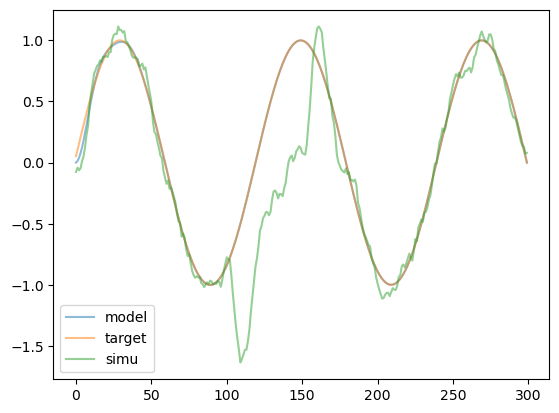

In [9]:
# check manual simulation
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets, alpha=0.5, label='target')
plt.plot(time_points, outputs_nofb, alpha=0.5, label='simu')
plt.legend()
plt.show()

## LQR

In [10]:
# controlability matrix
Ctrl = control.ctrb(A,B)
print(Ctrl)
print(np.linalg.matrix_rank(Ctrl))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.97299494e+11
  -5.65781906e+11 -4.88256648e+11]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ... -1.65808195e+11
  -5.05146751e+11 -4.23181585e+11]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -3.00149522e+11
  -8.18684722e+10 -4.05305761e+11]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.88319969e+11
  -1.87229504e+10 -3.63368879e+11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.99637006e+11
  -1.13001991e+11 -4.18164660e+11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.15486798e+11
  -1.88045166e+11 -3.46993785e+11]]
23


In [11]:
# lqr
K, _, E = control.lqr(A,B,Q,R)
print(K.shape)
K

(32, 32)


array([[ 9.07325158e+00, -1.07294338e-01, -1.33961226e-01, ...,
        -2.63180895e-01, -1.72021633e-02, -4.91828750e-02],
       [-1.07294338e-01,  9.06127176e+00,  3.71647413e-03, ...,
        -1.09386771e-01, -3.16168993e-02, -9.10412932e-03],
       [-1.33961226e-01,  3.71647413e-03,  9.05196143e+00, ...,
         1.58637615e-02,  5.23364101e-02,  9.60242254e-02],
       ...,
       [-2.63180895e-01, -1.09386771e-01,  1.58637615e-02, ...,
         9.04694746e+00,  3.33570974e-02,  1.05678694e-01],
       [-1.72021633e-02, -3.16168993e-02,  5.23364101e-02, ...,
         3.33570974e-02,  9.04116810e+00,  1.34080791e-01],
       [-4.91828750e-02, -9.10412932e-03,  9.60242254e-02, ...,
         1.05678694e-01,  1.34080791e-01,  9.06681558e+00]])

In [12]:
# manual simulation with feedback
c = network.timestep/network.time_const
activations_fb = [init_activations]
outputs_fb = []
ideal_activations = activations.detach().numpy()

for t in time_points:
    last_acitvation = activations_fb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    # this_noise = 0
    this_ideal_activation = ideal_activations[t,:].T

    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * this_input + c * this_noise + c * B @ (-K @ (last_acitvation - this_ideal_activation))
    this_output = output_weight_matrix @ this_activation
    activations_fb.append(this_activation)
    outputs_fb.append(this_output.item())

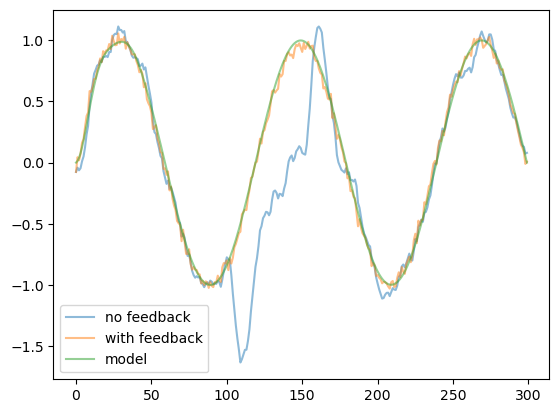

In [13]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='no feedback')
plt.plot(time_points, outputs_fb, alpha=0.5, label='with feedback')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()

## Kalman Filter

In [14]:
Obsv = control.obsv(A, C)
np.linalg.matrix_rank(Obsv)

23

In [15]:
L, _, _ = control.lqe(A, G, C, Qn, Rn)
L

array([[ 0.48182891, -0.01007166, -0.00071814, ..., -0.05459134,
         0.00374898,  0.01390542],
       [-0.01007166,  0.45651613,  0.0299825 , ..., -0.00483657,
         0.006558  ,  0.02576787],
       [-0.00071814,  0.0299825 ,  0.43834478, ..., -0.00063888,
         0.01870685,  0.02061091],
       ...,
       [-0.05459134, -0.00483657, -0.00063888, ...,  0.45855655,
         0.0079002 ,  0.03130165],
       [ 0.00374898,  0.006558  ,  0.01870685, ...,  0.0079002 ,
         0.4274495 ,  0.02656084],
       [ 0.01390542,  0.02576787,  0.02061091, ...,  0.03130165,
         0.02656084,  0.41418206]])

In [16]:
# manual simulation without feedback
kx_init = np.zeros((num_nodes, 1))
u = np.zeros((num_nodes, 1))
kxs = [kx_init]

activations_nofb = [init_activations]
outputs_nofb = []
ys_nofb = []

for t in time_points:
    # dynamic system
    last_acitvation = activations_nofb[-1]
    this_input = inputs[t] * input_weights.T
    this_noise = x_noises[:,t]
    this_ynoise = y_noises[:,t]

    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * B @ this_input + c * G @ this_noise
    this_output = output_weight_matrix @ this_activation
    this_y = C @ this_activation + this_ynoise

    activations_nofb.append(this_activation)
    outputs_nofb.append(this_output.item())
    ys_nofb.append(this_y)

    # kalman system
    last_kx = kxs[-1]
    theo_this_kx = (1 - c) * last_kx + c * weight_matrix @ last_kx + c * B @ this_input
    # theo_this_y = C @ theo_this_kx
    theo_this_y = C @ last_kx
    this_kx = theo_this_kx + c * L @ (this_y - theo_this_y)
    # this_kx = (1 - c) * last_kx + c * weight_matrix @ last_kx + c * B @ this_input + L @ this_y - L @ (C @ last_kx)
    kxs.append(this_kx)

In [17]:
diffs = [np.sum(np.power(x[0] - x[1],2))/num_nodes for x in zip(activations_nofb, kxs)]
print(np.mean(diffs))

0.015368966533642173


In [18]:
koutputs = [(output_weight_matrix @ x).item() for x in kxs]
# koutputs

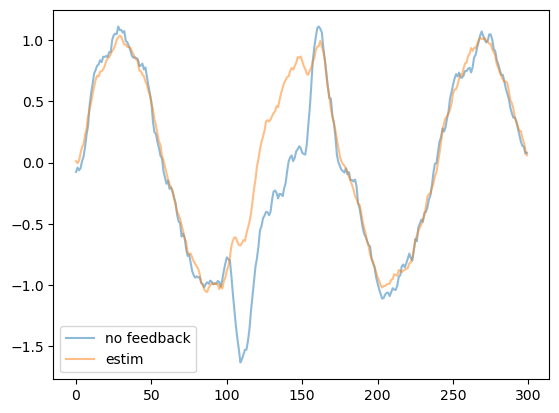

In [19]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='no feedback')
plt.plot(time_points, koutputs[1:], alpha=0.5, label='estim')
# plt.plot(time_points, outputs_fb, alpha=0.5, label='with feedback')
# plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()

### Combine LQG

In [20]:
# lqr
K, _, _ = control.lqr(A,B,Q,R)
print(K.shape)
K

(32, 32)


array([[ 9.07325158e+00, -1.07294338e-01, -1.33961226e-01, ...,
        -2.63180895e-01, -1.72021633e-02, -4.91828750e-02],
       [-1.07294338e-01,  9.06127176e+00,  3.71647413e-03, ...,
        -1.09386771e-01, -3.16168993e-02, -9.10412932e-03],
       [-1.33961226e-01,  3.71647413e-03,  9.05196143e+00, ...,
         1.58637615e-02,  5.23364101e-02,  9.60242254e-02],
       ...,
       [-2.63180895e-01, -1.09386771e-01,  1.58637615e-02, ...,
         9.04694746e+00,  3.33570974e-02,  1.05678694e-01],
       [-1.72021633e-02, -3.16168993e-02,  5.23364101e-02, ...,
         3.33570974e-02,  9.04116810e+00,  1.34080791e-01],
       [-4.91828750e-02, -9.10412932e-03,  9.60242254e-02, ...,
         1.05678694e-01,  1.34080791e-01,  9.06681558e+00]])

In [21]:
# Kalman filter
L, _, _ = control.lqe(A, G, C, Qn, Rn)
print(L.shape)
L

(32, 32)


array([[ 0.48182891, -0.01007166, -0.00071814, ..., -0.05459134,
         0.00374898,  0.01390542],
       [-0.01007166,  0.45651613,  0.0299825 , ..., -0.00483657,
         0.006558  ,  0.02576787],
       [-0.00071814,  0.0299825 ,  0.43834478, ..., -0.00063888,
         0.01870685,  0.02061091],
       ...,
       [-0.05459134, -0.00483657, -0.00063888, ...,  0.45855655,
         0.0079002 ,  0.03130165],
       [ 0.00374898,  0.006558  ,  0.01870685, ...,  0.0079002 ,
         0.4274495 ,  0.02656084],
       [ 0.01390542,  0.02576787,  0.02061091, ...,  0.03130165,
         0.02656084,  0.41418206]])

In [22]:
# manual simulation with kalman and lqr
activations_lqg = [init_activations]
activations_hat = [init_activations]
ideal_activations = activations.detach().numpy()
outputs_lqg = []

for t in np.arange(nt):

    # lqr
    last_acitvation_hat = activations_hat[-1]
    # last_acitvation_hat = activations_lqg[-1] # test without kalman
    this_ideal_activation = ideal_activations[t,:].reshape(-1,1)
    this_u = -K @ (last_acitvation_hat - this_ideal_activation)
    # this_u = np.ones((num_nodes,1)) # test without lqr

    # dynamic system
    last_acitvation = activations_lqg[-1]
    this_input = inputs[t] * input_weights.T
    this_xnoise = x_noises[:,t].reshape(-1,1)
    this_ynoise = y_noises[:,t].reshape(-1,1)
    
    this_activation = (1 - c) * last_acitvation + c * weight_matrix @ last_acitvation + c * B @ this_input + c * B @ this_u + c * G @ this_xnoise
    this_output = output_weight_matrix @ this_activation
    this_y = C @ this_activation + this_ynoise
    
    activations_lqg.append(this_activation)
    outputs_lqg.append(this_output.item())

    # Kalman system
    theo_this_kx = (1 - c) * last_acitvation_hat + c * weight_matrix @ last_acitvation_hat + c * B @ this_input + c * B @ this_u
    # theo_this_kx = (1 - c) * last_acitvation_hat + c * weight_matrix @ last_acitvation_hat + c * B @ this_input
    theo_this_y = C @ theo_this_kx
    # theo_this_y = C @ last_acitvation_hat
    this_acitvation_hat = theo_this_kx + c * L @ (this_y - theo_this_y)
    activations_hat.append(this_acitvation_hat)

    # print(np.mean(np.abs(this_acitvation_hat - this_activation)))

In [23]:
diffs = [np.sum(np.power(x[0] - x[1],2))/num_nodes for x in zip(activations_lqg, activations_hat)]
print(np.mean(diffs))

0.0142671803314184


In [24]:
tt = []
df = []
for i in range(len(ideal_activations)):
    p = activations_hat[i+1] - ideal_activations[i,:].reshape(-1,1)
    tmp = output_weight_matrix @ p
    tmp = tmp.item()

    tt.append(tmp)
    df.append(np.mean(np.power(p,2)))
print(np.mean(df))

0.0017415879625377665


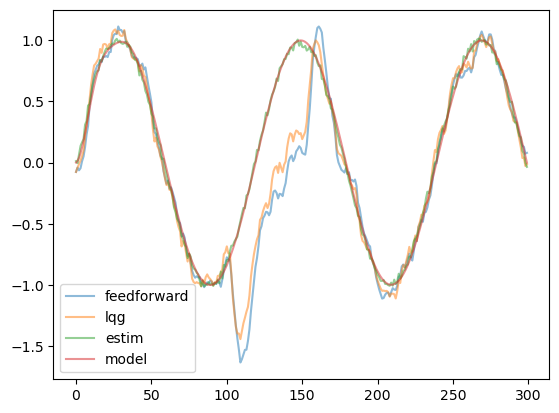

In [25]:
# check feedback
plt.plot(time_points, outputs_nofb, alpha=0.5, label='feedforward')
plt.plot(time_points, outputs_lqg, alpha=0.5, label='lqg')
kkoutputs = [(output_weight_matrix @ x).item() for x in activations_hat]
plt.plot(time_points, kkoutputs[1:], alpha=0.5, label='estim')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.legend()
plt.show()